In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import arviz as az
import pymc as pm
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform
from REStats.models import fit_weibull, calc_persistence, backtest
from REStats.plots import save_figs

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
sns.set_theme()

In [3]:
wt = load_SCADA(2020)

In [4]:
SAVE_FIGS = True
figs = {}

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

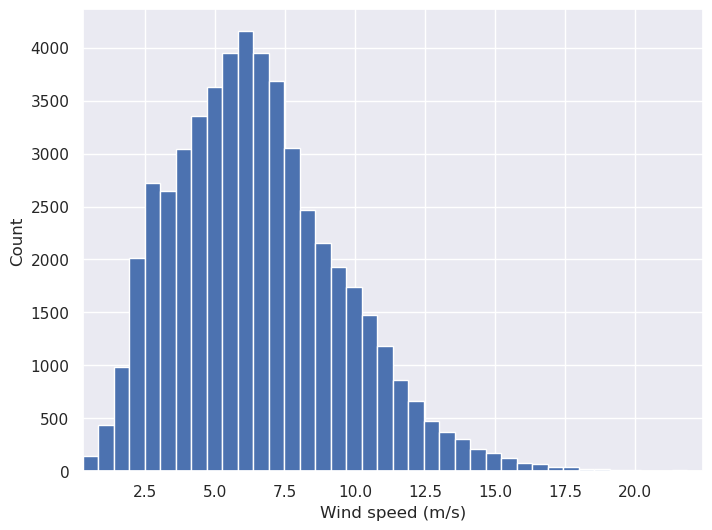

In [5]:
full_ws_hist, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Count")

b = ax.hist(wt["Wind speed"], bins=40)

figs["full_ws_hist"] = full_ws_hist

In [6]:
wt_1m = wt[(wt.index >= "2020-01-01") & (wt.index < "2020-02-01")]

ws = wt_1m[["Wind speed"]]

# Resample to hourly

vh = ws.resample("H").mean()

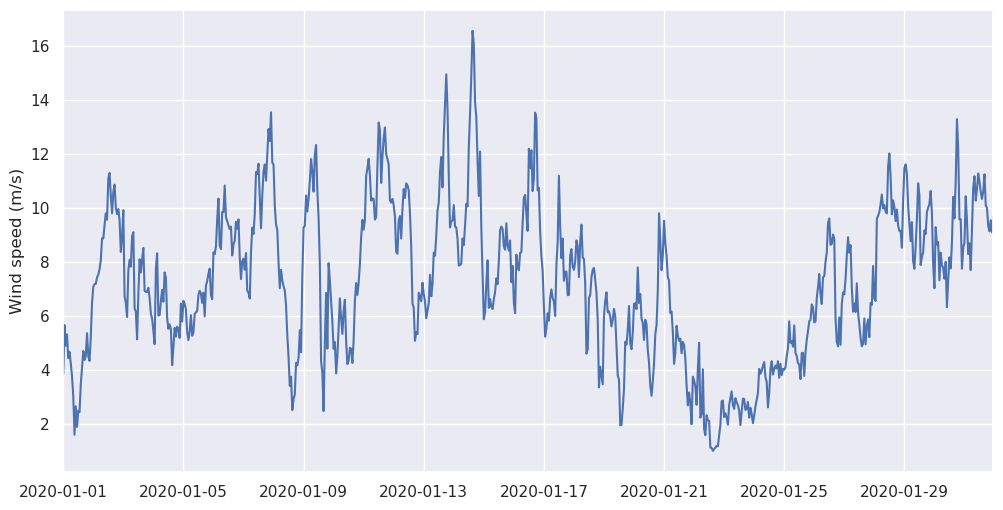

In [7]:
training_raw, ax = plt.subplots(figsize=(12, 6))

ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(vh.index, vh)

figs["training_raw"] = training_raw

In [8]:
vh.isnull().sum() == 0, len(vh)

(Wind speed    True
 dtype: bool,
 744)

## Processing: Weibull fit

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [9]:
idata_wb = fit_weibull(vh)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
Sampling: [y]


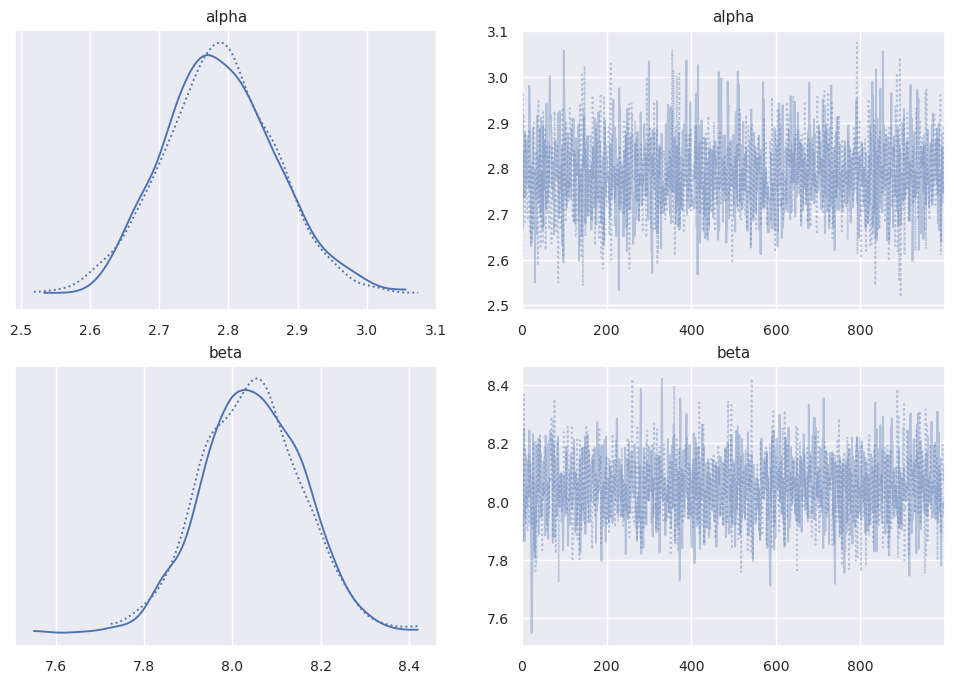

In [10]:
az.plot_trace(idata_wb, figsize=(12, 8))

wb_trace = plt.gcf()
figs["wb_trace"] = wb_trace

In [11]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 744 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1818.66    16.65
p_loo        2.08        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      744  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

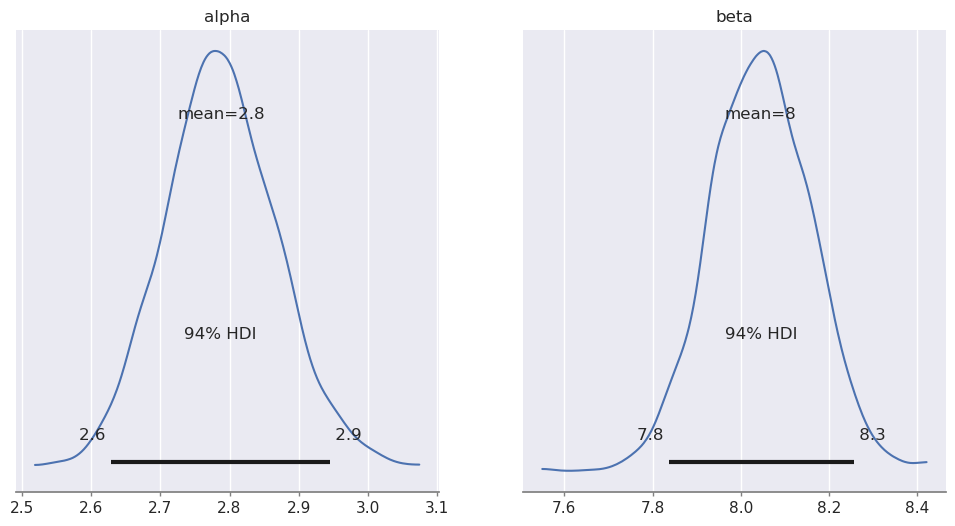

In [12]:
az.plot_posterior(idata_wb, figsize=(12, 6))

wb_posterior = plt.gcf()

figs["wb_posterior"] = wb_posterior

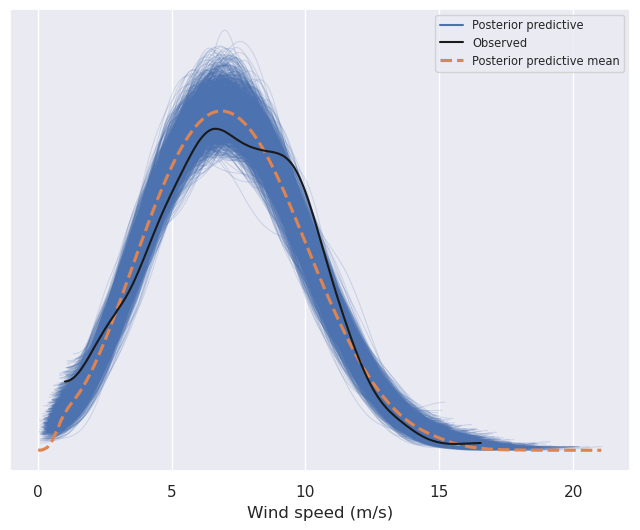

In [13]:
wb_ppc, ax = plt.subplots(figsize=(8, 6))

az.plot_ppc(idata_wb, ax=ax)
ax.set_xlabel("Wind speed (m/s)")

figs["wb_ppc"] = wb_ppc

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [14]:
shape = idata_wb.posterior.alpha.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.beta.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.7743571325982379


## Modeling

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

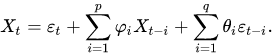

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


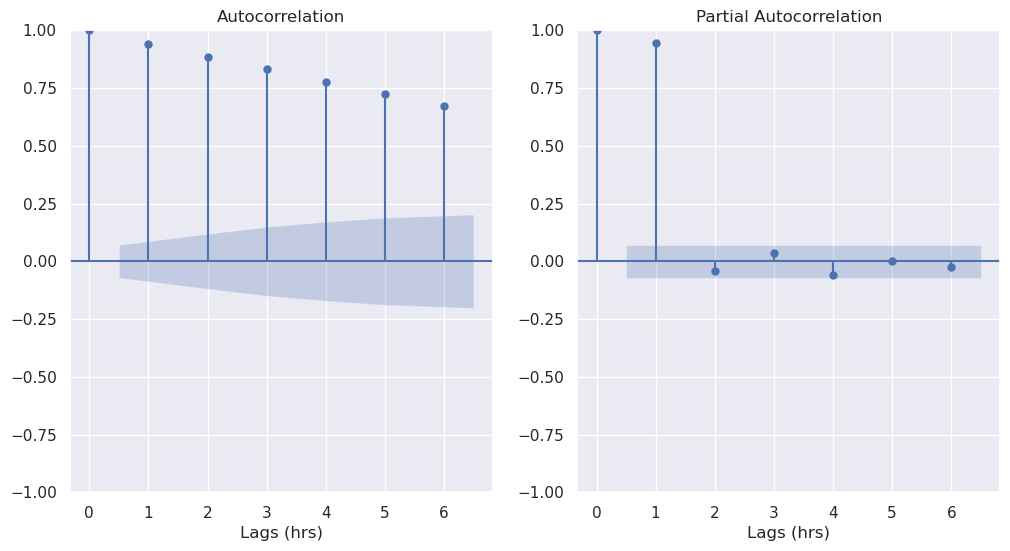

In [15]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(vh, lags=6, ax=axes[0])
autocorrelation = plot_pacf(vh, lags=6, ax=axes[1])

figs["autocorrelation"] = autocorrelation

In [16]:
v_tf, hr_stats = transform(vh, m, field="Wind speed")

v_tf.head()

,Wind speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2020-01-01 00:00:00,3.867503,2.850238,3.867503,0,-1.313630
2020-01-01 01:00:00,5.663008,3.829371,5.663008,1,-0.553223
2020-01-01 02:00:00,4.896892,3.421723,4.896892,2,-0.966483
2020-01-01 03:00:00,5.320999,3.649035,5.320999,3,-0.866238
2020-01-01 04:00:00,4.438020,3.170703,4.438020,4,-1.403343


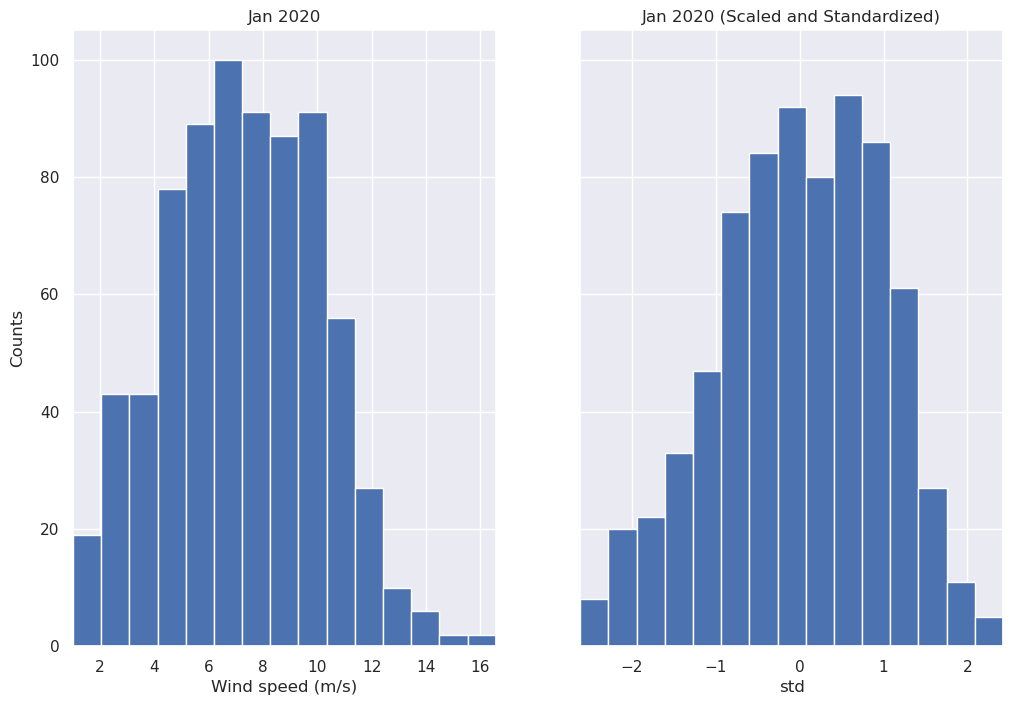

In [17]:
ws_hist_std_comparison, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(v_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(v_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

figs["ws_hist_std_comparison"] = ws_hist_std_comparison

In [18]:
arma_mod = ARIMA(v_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  744
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -223.106
Date:                Tue, 14 Mar 2023   AIC                            456.211
Time:                        16:58:15   BIC                            479.271
Sample:                    01-01-2020   HQIC                           465.100
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4068      0.238      1.711      0.087      -0.059       0.873
ar.L2          0.5156      0.221      2.329      0.020       0.082       0.949
ma.L1          0.5420      0.237      2.291      0.0

In [19]:
pred = arma_res.get_prediction().summary_frame()
pred = pred.copy()
pred

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2020-01-01 00:00:00,0.000000,0.989457,-1.939300,1.939300
2020-01-01 01:00:00,-1.239540,0.327601,-1.881626,-0.597454
2020-01-01 02:00:00,-0.522244,0.327601,-1.164330,0.119842
2020-01-01 03:00:00,-0.973147,0.326618,-1.613306,-0.332989
2020-01-01 04:00:00,-0.756447,0.326333,-1.396047,-0.116846
...,...,...,...,...
2020-01-31 19:00:00,0.689771,0.326088,0.050651,1.328891
2020-01-31 20:00:00,0.623070,0.326088,-0.016049,1.262190
2020-01-31 21:00:00,0.595296,0.326088,-0.043824,1.234416


Reverse the transformations for error calculations and plotting.

In [20]:
inv_pred = inv_transform(pred, m, hr_stats)
rmse = mean_squared_error(v_tf.v, inv_pred["mean"], squared=False)
print("RMSE:", rmse)

RMSE: 0.8954995654862574


In [21]:
per = v_tf.v.shift(1).bfill()
per_rmse = mean_squared_error(v_tf.v, per, squared=False)
per_rmse

0.9417434296080975

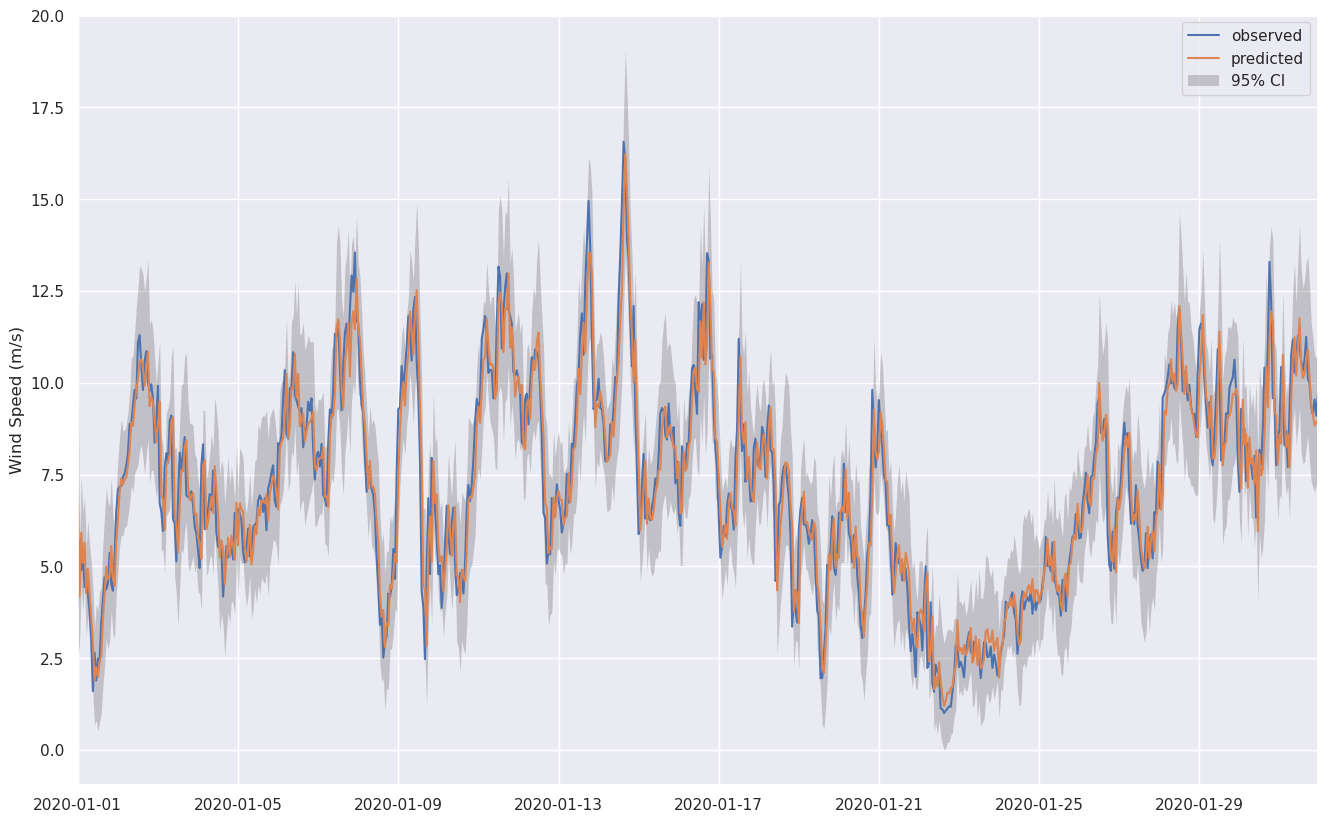

In [22]:
arma_fit_results, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(v_tf.index, v_tf.v, label="observed")

ax.plot(inv_pred.index, inv_pred["mean"], label="predicted")
ax.fill_between(
    inv_pred.index, 
    inv_pred.mean_ci_lower, 
    inv_pred.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()

figs["arma_fit_results"] = arma_fit_results

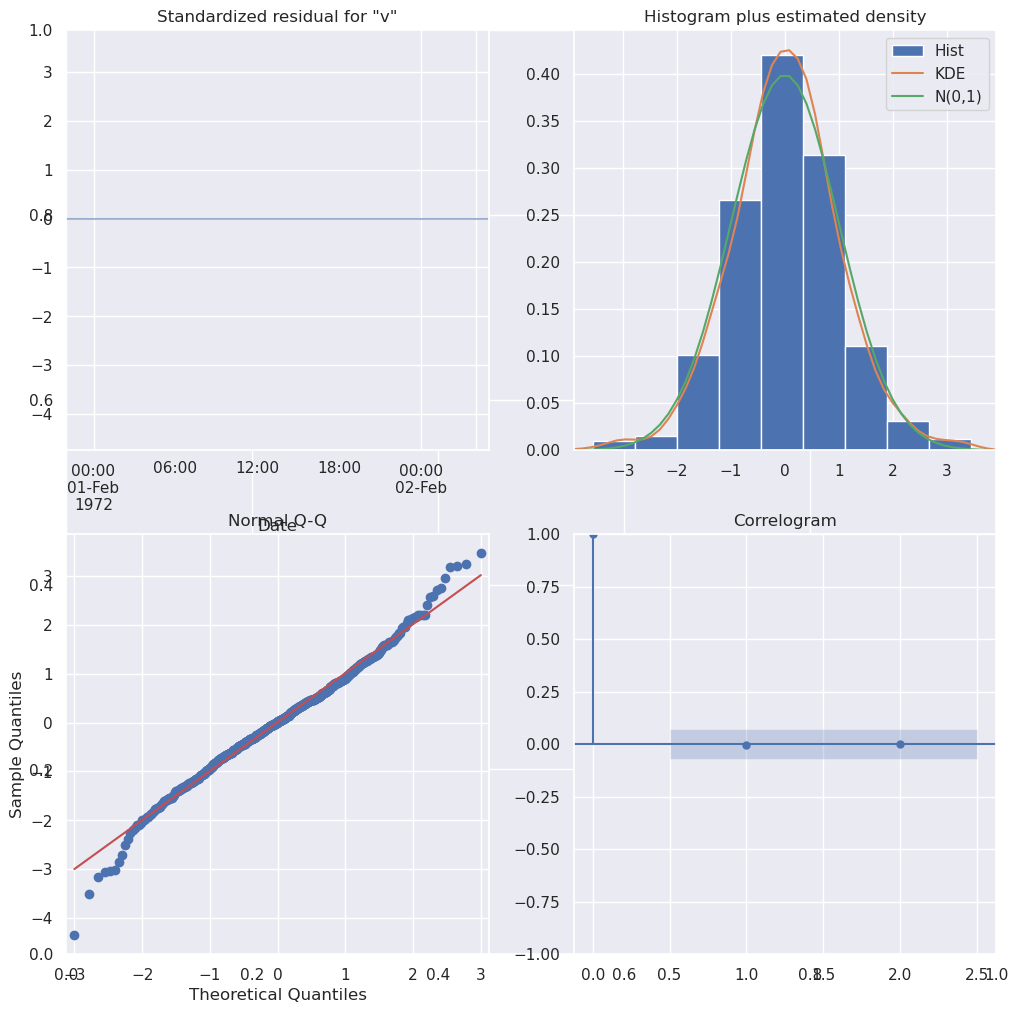

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

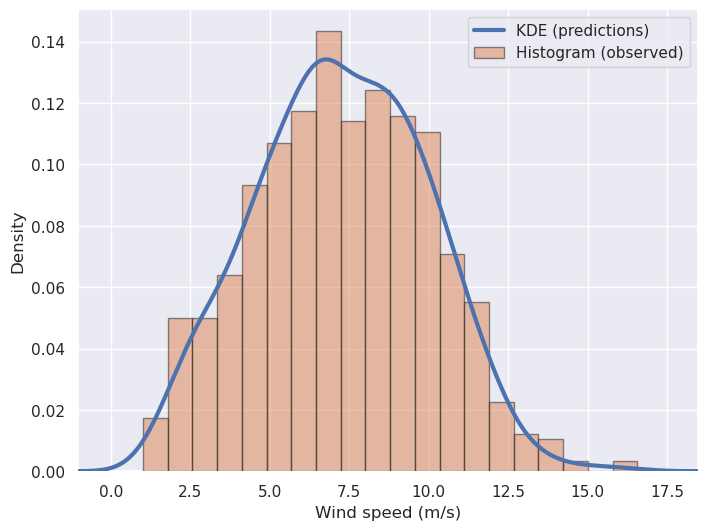

In [24]:
kde = sm.nonparametric.KDEUnivariate(inv_pred["mean"])
kde.fit()  # Estimate the densities

arma_fit_kde, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    v_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

figs["arma_fit_kde"] = arma_fit_kde

## Forecast

In [25]:
wt_train = wt[(wt.index >= "2020-01-01") & (wt.index < "2020-02-01")].copy()
wt_test = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")].copy()

v_train = wt_train[["Wind speed"]].resample("H").mean()
assert v_train["Wind speed"].isnull().sum() == 0 # sanity check
v_test = wt_test[["Wind speed"]].resample("H").mean()
assert v_test["Wind speed"].isnull().sum() == 0 # sanity check

In [26]:
forecasts_full, (fcast_rmse, fcast_mae) = backtest(v_train, v_test)

forecasts_full.head()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
Sampling: [y]


Forecast RMSE: 1.2969671384727786
Forecast MAE: 1.0053961482850287


v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-02-01 01:00:00,9.282738,7.691246,7.724790,10.902224
2020-02-01 02:00:00,9.627928,7.984036,7.986015,11.335789
2020-02-01 03:00:00,8.237459,7.954336,6.783964,9.751458
2020-02-01 04:00:00,9.241275,7.815804,7.890491,10.638251
2020-02-01 05:00:00,9.826786,7.791629,8.373017,11.330894


In [27]:
calc_persistence(v_test["Wind speed"])

PER RMSE: 1.262842907899758
PER MAE: 0.9678074320673253


(1.262842907899758, 0.9678074320673253)

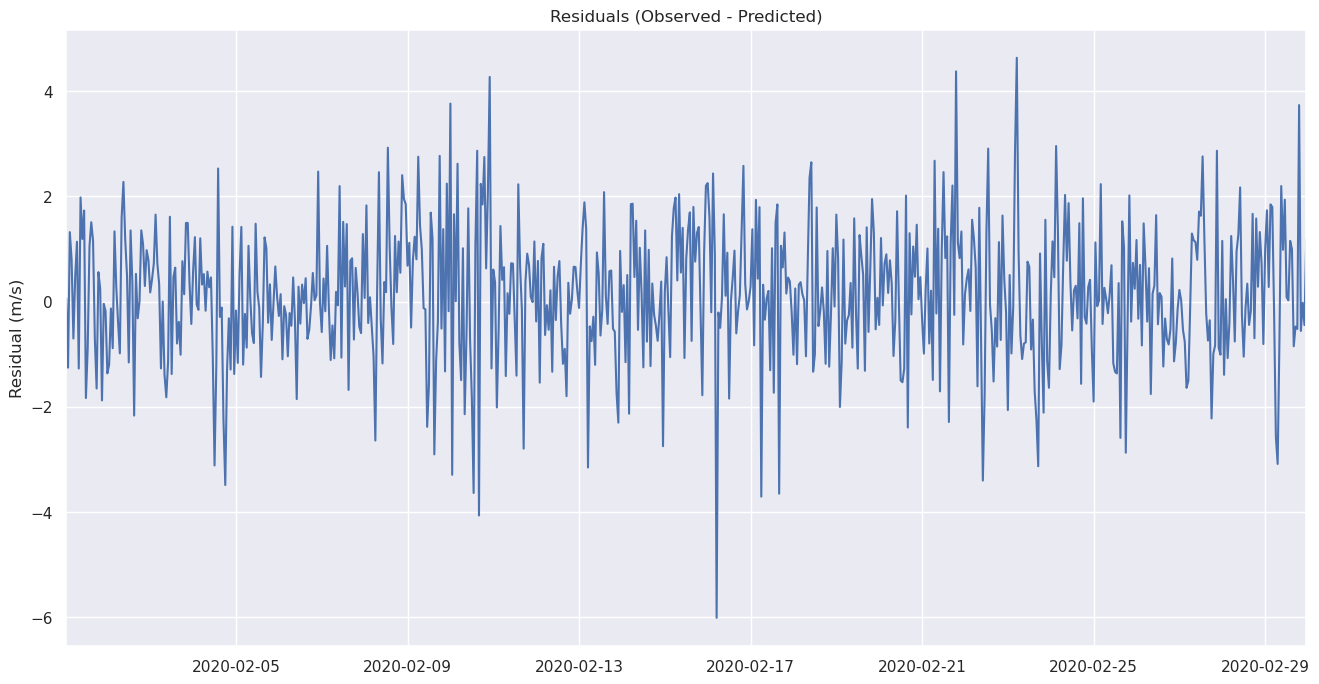

In [28]:
arma_forecast_resid, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Residual (m/s)")
ax.set_xmargin(0)
ax.set_title("Residuals (Observed - Predicted)")

resid = v_test["Wind speed"][1:] - forecasts_full["mean"]

ax.plot(forecasts_full.index, resid)

figs["arma_forecast_resid"] = arma_forecast_resid

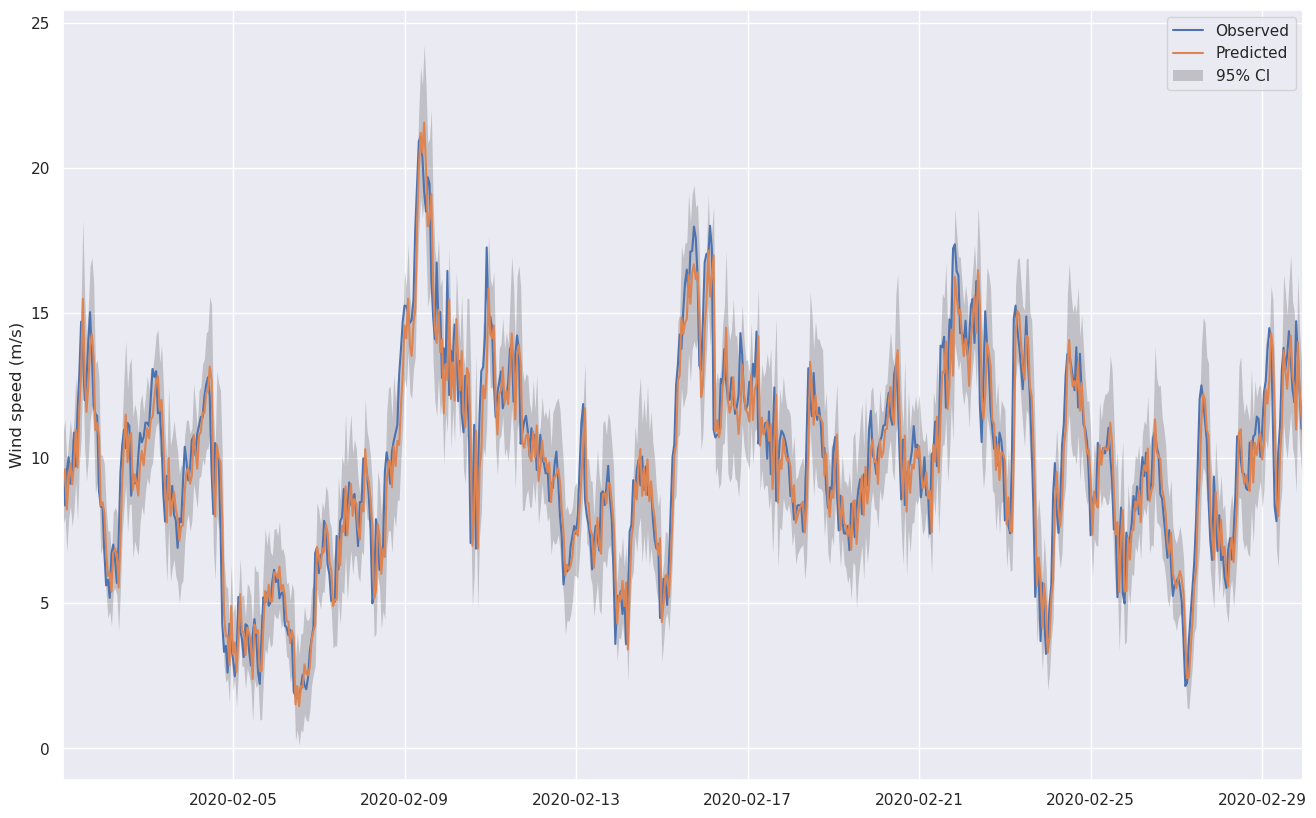

In [29]:
arma_forecast_results, ax = plt.subplots(figsize=(16, 10))
ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(v_test.index[1:], v_test[1:], label="Observed")
ax.plot(forecasts_full.index, forecasts_full["mean"], label="Predicted")


ax.fill_between(
    forecasts_full.index, 
    forecasts_full.mean_ci_lower, 
    forecasts_full.mean_ci_upper,
    color="k", alpha=.2, linewidth=0, label="95% CI"
)

ax.legend()

figs["arma_forecast_results"] = arma_forecast_results

In [30]:
if SAVE_FIGS:
    save_figs(figs)